In [1]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import sys
import os
import random 
import warnings
import math
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Experiment Hyperparameters

In [2]:
is_local = True # todo

# Experiment
seed = 1000 if is_local else int(sys.argv[-2])
torch.manual_seed(seed)
image_size = 256

# Data: which wavenumbers are even allowed to be considered?
wv_start = 0
wv_end = 965

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 2 # todo see how high can get on csf
use_augmentation = True

# Network
dropout_p=0

# Training schedule
lr = 5e-4
l2 = 5e-2
max_epochs=200

# dimensionality reduction parameters
r_method = 'linear' # {'linear','pca,'fixed'}
reduce_dim = 16 if is_local else int(sys.argv[-1]) # todo 
channels_used = np.s_[...,wv_start:wv_end] # used only when r_method = 'fixed'

In [3]:
def csf_fp(filepath):
    return filepath.replace('D:/datasets','D:/datasets' if is_local else './')

master = pd.read_excel(csf_fp(rf'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx'))
slide = master['slide'].to_numpy()
patient_id = master['patient_id'].to_numpy()
hdf5_filepaths = np.array([csf_fp(fp) for fp in master['hdf5_filepath']])
annotation_filepaths = np.array([csf_fp(fp) for fp in master['annotation_filepath']])
mask_filepaths = np.array([csf_fp(fp) for fp in master['mask_filepath']])
wavenumbers = np.load(csf_fp(f'D:/datasets/pcuk2023_ftir_whole_core/wavenumbers.npy'))[wv_start:wv_end]
wavenumbers_used = wavenumbers[channels_used]

annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)
print(f"Loaded {len(slide)} cores")
print(f"Using {len(wavenumbers_used)}/{len(wavenumbers)} wavenumbers")

Loaded 228 cores
Using 965/965 wavenumbers


## Define Datasets, Dataloaders

In [4]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(
    unique_pids, np.zeros_like(unique_pids), test_size=test_set_fraction, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(
    pids_trainval, np.zeros_like(pids_trainval), test_size=(val_set_fraction/(1-test_set_fraction)), random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))
print(f"Patients per data split:\n\tTRAIN: {len(where_train[0])}\n\tVAL: {len(where_val[0])}\n\tTEST: {len(where_test[0])}")

Patients per data split:
	TRAIN: 130
	VAL: 51
	TEST: 47


In [5]:
class ftir_annot_dataset(torch.utils.data.Dataset):
    def __init__(self, 
                 hdf5_filepaths, mask_filepaths, annotation_filepaths, channels_use, augment=False):
        self.hdf5_filepaths = hdf5_filepaths
        self.mask_filepaths = mask_filepaths
        self.annotation_filepaths = annotation_filepaths
        self.channels_use = channels_use
        self.augment=augment
        
        # class data
        self.annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
        self.annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
        
    def __len__(self):
        return len(self.hdf5_filepaths)
    
    # split annotations from H x W x 3 to C x H x W, one/zerohot along C dimension
    def split_annotations(self,annotations_img):
        split = torch.zeros((len(self.annotation_class_colors),*annotations_img.shape[:-1]))
        for c,col in enumerate(annotation_class_colors):
            split[c,:,:] = torch.from_numpy(np.all(annotations_img == self.annotation_class_colors[c],axis=-1)) 
        return split
        
    def __getitem__(self, idx):    
        
        # open hdf5 file
        hdf5_file = h5py.File(self.hdf5_filepaths[idx],'r')
        
        # get mask
        mask = torch.from_numpy(
            hdf5_file['mask'][:],
        ).unsqueeze(0)
        
        # get ftir
        ftir = torch.from_numpy(
            hdf5_file['spectra'][*self.channels_use],
        ).permute(2,0,1)
        hdf5_file.close()
        ftir *= mask
        
        # get annotations
        annotations = self.split_annotations(cv2.imread(self.annotation_filepaths[idx])[:,:,::-1])
        annotations *= mask
        has_annotations = annotations.sum(dim=0) != 0
        
        if self.augment:
            to_aug = torch.rand((2,))
            if to_aug[0] > 0.5: #hflip
                ftir = torch.flip(ftir, (-1,))
                annotations = torch.flip(annotations, (-1,))
                has_annotations = torch.flip(has_annotations, (-1,))
                mask = torch.flip(mask, (-1,))
            if to_aug[1] > 0.5: #vflip
                ftir = torch.flip(ftir, (-2,))
                annotations = torch.flip(annotations, (-2,))
                has_annotations = torch.flip(has_annotations, (-2,))
                mask = torch.flip(mask, (-2,))
        
        return ftir, annotations, mask, has_annotations

In [6]:
dataset_train = ftir_annot_dataset(
    hdf5_filepaths[where_train], mask_filepaths[where_train], annotation_filepaths[where_train], channels_used, augment=use_augmentation,
)
dataset_val = ftir_annot_dataset(
    hdf5_filepaths[where_val], mask_filepaths[where_val], annotation_filepaths[where_val], channels_used, augment=False,
)
dataset_test = ftir_annot_dataset(
    hdf5_filepaths[where_test], mask_filepaths[where_test], annotation_filepaths[where_test], channels_used, augment=False,
)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,drop_last=True)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 65
	val: 25
	test: 23


## Define dimensionality reduction method

In [7]:
class LinearReduction(nn.Module):
    def __init__(self,input_dim,reduce_dim):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.input_norm = nn.BatchNorm2d(input_dim)
        self.projection = nn.Conv2d(input_dim,reduce_dim,kernel_size=1,stride=1)
        self.projection_norm = nn.BatchNorm2d(reduce_dim)
    
    def forward(self,x):
        return self.projection_norm(self.projection(self.input_norm(x)))
    
class PCAReduce(nn.Module):
    def __init__(self,reduce_dim,means,loadings):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.register_buffer('means', torch.from_numpy(means).float().reshape(1,-1,1,1))
        self.register_buffer('loadings', torch.from_numpy(loadings).float())
    
    def forward(self,x):
        projected = x - self.means
        
        b,c,h,w = projected.shape
        projected = projected.permute(0,2,3,1).reshape(b,h*w,c)
        projected = torch.matmul(projected, self.loadings.T)
        projected = projected.reshape(b,h,w,self.reduce_dim).permute(0,3,1,2)
        
        return projected
        
class FixedReduction(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.input_norm = nn.BatchNorm2d(input_dim)
    
    def forward(self,x):
        return self.input_norm(x)

if r_method == 'pca':
    spectral_sample = []
    batch_samples = 0
    for data, annotations, mask, has_annotations in train_loader:
        where = torch.where(has_annotations[0] == 1)
        ridxs = torch.randperm(where[0].shape[0])[:100]
        spectral_sample.append(data[:, :, where[0][ridxs],where[1][ridxs]].permute(0,2,1).flatten(0,1).numpy())
        batch_samples += 1
        if batch_samples > 10: break
    spectral_sample = np.concatenate(spectral_sample,axis=0)
    spectral_means = np.mean(spectral_sample,axis=0)
    spectral_sample -= spectral_means
    pca = PCA(n_components=reduce_dim)
    pca.fit(spectral_sample)
    spectral_loadings = pca.components_
    
if r_method == 'pca':
    input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
elif r_method == 'fixed':
    input_processing = FixedReduction(input_dim=len(wavenumbers_used))
elif r_method == 'linear':
    input_processing = LinearReduction(input_dim=len(wavenumbers_used),reduce_dim=reduce_dim)

## Define Model

In [8]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn(
            "mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
            "The distribution of values may be incorrect.",
            stacklevel=2,
        )

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.0))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

class PatchEmbedPerChannel(nn.Module):
    """Image to Patch Embedding."""

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        enable_sample: bool = True,
    ):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size) * in_chans
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv3d(
            1,
            embed_dim,
            kernel_size=(1, patch_size, patch_size),
            stride=(1, patch_size, patch_size),
        )  # CHANGED

        self.channel_embed = nn.Embedding(in_chans, embed_dim)
        self.enable_sample = enable_sample

        trunc_normal_(self.channel_embed.weight, std=0.02)

    def forward(self, x, extra_tokens={}):
        # # assume all images in the same batch has the same input channels
        # cur_channels = extra_tokens["channels"][0]
        # embedding lookup
        cur_channel_embed = self.channel_embed(
            extra_tokens["channels"]
        )  # B, Cin, embed_dim=Cout
        cur_channel_embed = cur_channel_embed.permute(0, 2, 1)  # B Cout Cin

        B, Cin, H, W = x.shape
        # Note: The current number of channels (Cin) can be smaller or equal to in_chans

        if self.training and self.enable_sample:
            # Per batch channel sampling
            # Note this may be slow
            # Randomly sample the number of channels for this batch
            Cin_new = random.randint(1, Cin)

            # Randomly sample the selected channels
            channels = random.sample(range(Cin), k=Cin_new)
            
            Cin = Cin_new
            x = x[:, channels, :, :]

            # Update the embedding lookup
            cur_channel_embed = cur_channel_embed[:, :, channels]
            ######

        # shared projection layer across channels
        x = self.proj(x.unsqueeze(1))  # B Cout Cin H W

        # channel specific offsets
        x += cur_channel_embed.unsqueeze(-1).unsqueeze(-1)
        # x += self.channel_embed[:, :, cur_channels, :, :]  # B Cout Cin H W

        # preparing the output sequence
        x = x.flatten(2)  # B Cout CinHW
        x = x.transpose(1, 2)  # B CinHW Cout

        return x, Cin

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn
    
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x    

def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class ChannelVisionTransformer(nn.Module):
    """Channel Vision Transformer"""

    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_classes=0,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        enable_sample=True,
        **kwargs,
    ):
        super().__init__()
        print(
            "Warning!!!\n"
            "Samplev2 channel vit randomly sample channels for each batch.\n"
            "It is only compatible with Supervised learning\n"
            "Doesn't work with DINO or Linear Prob"
        )

        self.num_features = self.embed_dim = self.out_dim = embed_dim
        self.in_chans = in_chans
        
        if r_method == 'pca':
            self.input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
        elif r_method == 'fixed':
            self.input_processing = FixedReduction(input_dim=len(wavenumbers_used))
        elif r_method == 'linear':
            self.input_processing = LinearReduction(input_dim=len(wavenumbers_used),reduce_dim=reduce_dim)

        self.patch_embed = PatchEmbedPerChannel(
            img_size=img_size[0],
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            enable_sample=enable_sample,
        )
        num_patches = self.patch_embed.num_patches
        self.patches_per_channel = self.patch_embed.num_patches // reduce_dim
        self.patch_size=patch_size

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.num_extra_tokens = 1  # cls token

        self.pos_embed = nn.Parameter(
            torch.zeros(
                1, num_patches // self.in_chans + self.num_extra_tokens, embed_dim
            )
        )

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # stochastic depth decay rule
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.upscale = nn.ConvTranspose2d(embed_dim,embed_dim,kernel_size=16,stride=16)
        self.out_conv = nn.Sequential(
            nn.Conv2d(embed_dim+reduce_dim,embed_dim,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim,embed_dim,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim,n_classes,kernel_size=3,stride=1,padding=1),
        )

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h, c):
        num_extra_tokens = self.patches_per_channel

        npatch = x.shape[1] - num_extra_tokens
        N = self.pos_embed.shape[1] - num_extra_tokens

        if npatch == N and w == h:
            return self.pos_embed

        class_pos_embed = self.pos_embed[:, :num_extra_tokens]
        patch_pos_embed = self.pos_embed[:, num_extra_tokens:]

        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(
                1, int(math.sqrt(N)), int(math.sqrt(N)), dim
            ).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode="bicubic",
        )
        assert (
            int(w0) == patch_pos_embed.shape[-2]
            and int(h0) == patch_pos_embed.shape[-1]
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, 1, -1, dim)

        # create copies of the positional embeddings for each channel
        patch_pos_embed = patch_pos_embed.expand(1, c, -1, dim).reshape(1, -1, dim)

        return torch.cat((class_pos_embed, patch_pos_embed), dim=1)

    def prepare_tokens(self, x, extra_tokens):
        B, nc, w, h = x.shape
        x, nc = self.patch_embed(x, extra_tokens)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, self.patches_per_channel, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h, nc)

        return self.pos_drop(x)

    def forward(self, x, extra_tokens={}):
        b,c,h,w = x.shape
        x_proc = self.input_processing(x)
        x = self.prepare_tokens(x_proc, extra_tokens)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        # B x token x d_model -> B x d_model x token -> B x d_model x h x w -> B x 6 x H x W
        x = self.upscale(x[:, :self.patches_per_channel].permute(0,2,1).reshape(b,self.embed_dim,h//self.patch_size,w//self.patch_size))
        x = self.out_conv(torch.cat([x,x_proc],dim=1))
        return x
    

In [9]:
model = ChannelVisionTransformer(
    img_size=[image_size],
    patch_size=16,
    in_chans=reduce_dim, # todo change if not using linear reduc
    num_classes=n_classes,
    embed_dim=192, # todo
    depth=12,
    num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
)

model = model.to(device)
chn_tok = {"channels":torch.from_numpy(np.arange(0,reduce_dim)).unsqueeze(0).to(device)}

Warning!!!
Samplev2 channel vit randomly sample channels for each batch.
It is only compatible with Supervised learning
Doesn't work with DINO or Linear Prob


## Training Loop

In [10]:
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=15, threshold=0.01, cooldown=0)

In [11]:
training_losses,validation_losses = [],[]
training_accs,validation_accs = [],[]
training_f1ms,validation_f1ms = [],[]
training_f1s,validation_f1s = [],[]
lr_decreases = []
current_iters = 0
best_val_f1 = 0
best_val_iter = 0
stop_training=False

In [18]:
for epoch in range(max_epochs):
    print(f"\n ✰ ✰ ✰ EPOCH {epoch+1} ✰ ✰ ✰ ")
    
    # reset running metrics
    running_loss_train, running_loss_val = 0, 0
    train_preds,train_targets = [],[]
    val_preds,val_targets = [],[]
    
    # Train loop
    model.train()
    batch_frac = 42 / (len(train_loader))
    for batch_idx, (data, annot, mask, has_annotations) in enumerate(train_loader):
        print(f"train : {'█'*int(batch_idx*batch_frac)}", end="\r")
        
        # Put data and label on device
        data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
        
        # Push data through model
        optimizer.zero_grad()
        out = model(data,extra_tokens=chn_tok)
        
        # Calculate loss
        loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
        loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
        loss.backward() # backprop
        optimizer.step()
        
        # Calculate metrics
        running_loss_train += loss.cpu().item()
        targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
        preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
        train_preds.extend(preds.detach().cpu().numpy())
        train_targets.extend(targets.detach().cpu().numpy())
    print(f"train : {'█'*42}")
        
    # Validate loop
    model.eval()
    batch_frac = 42 / len(val_loader)
    with torch.no_grad():
        for batch_idx, (data, annot, mask, has_annotations) in enumerate(val_loader):
            print(f"val   : {'█'*int(batch_idx*batch_frac)}", end="\r")
            
            # Put data and label on device
            data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
            
            # Push data through model
            out = model(data,extra_tokens=chn_tok)
            
            # Calculate loss
            loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
            loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
            
            # Calculate metrics
            running_loss_val += loss.cpu().item()
            targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
            preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
            val_preds.extend(preds.detach().cpu().numpy())
            val_targets.extend(targets.detach().cpu().numpy())
    print(f"val   : {'█'*42}")
    
    # calculate epoch metrics for train set
    train_acc = accuracy_score(train_targets, train_preds); training_accs.append(train_acc)
    train_f1m = f1_score(train_targets, train_preds, average='macro'); training_f1ms.append(train_f1m)
    train_f1 = f1_score(train_targets, train_preds, average=None); training_f1s.append(train_f1)
    train_loss = running_loss_train / (len(dataset_train)); training_losses.append(train_loss)
    
    # calculate epoch metrics for val set
    val_acc = accuracy_score(val_targets, val_preds); validation_accs.append(val_acc)
    val_f1m = f1_score(val_targets, val_preds, average='macro'); validation_f1ms.append(val_f1m)
    val_f1 = f1_score(val_targets, val_preds, average=None); validation_f1s.append(val_f1)
    val_loss = running_loss_val / (len(dataset_val)); validation_losses.append(val_loss)
    
    # Update
    print(f"TRAIN --- | Loss: {train_loss:.4} | OA: {train_acc:.4} | f1: {train_f1m:.4}")
    print(f"VAL ----- | Loss: {val_loss:.4} | OA: {val_acc:.4} | f1: {val_f1m:.4}")
    
    scheduler.step(val_f1m)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != lr:
        print(f"Val f1 plateaued, lr {lr} -> {new_lr}")
        lr = new_lr
        lr_decreases.append(epoch)
        if len(lr_decreases) >= 3: 
            print("Val f1 decreased thrice, ending training early")
            break

    if val_f1m > best_val_f1:
        best_val_f1 = val_f1m
        best_val_epoch = epoch
        if not is_local:
            torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

if not is_local:
    model.load_state_dict(torch.load(rf'./model_weights_{seed}.pt', weights_only=True))


 ✰ ✰ ✰ EPOCH 1 ✰ ✰ ✰ 


KeyboardInterrupt: 

## Test Loop

In [ ]:
# Test
running_loss_test = 0
test_preds, test_targets = [], []
model.eval()
with torch.no_grad():
    for batch_idx, (data, annot, mask, has_annotations) in enumerate(test_loader):
        # Put data and label on device
        data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
        
        # Push data through model
        out = model(data,extra_tokens=chn_tok)
        
        # Calculate loss
        loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
        loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
        
        # Calculate metrics
        running_loss_test += loss.cpu().item()
        targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
        preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
        test_preds.extend(preds.detach().cpu().numpy())
        test_targets.extend(targets.detach().cpu().numpy())
        
        # Save pred figure todo remove
        if is_local:
            for b in range(data.shape[0]):
                bidx = (batch_idx*1) + b
                fig, ax = plt.subplots(figsize=(8, 4))
                predcore = annotation_class_colors[out[b].argmax(dim=0).detach().cpu().numpy()].reshape(256,256,3) / 255
                annotcolour = annotation_class_colors[annot[b].argmax(dim=0).cpu().numpy()] / 255
                predcore *= mask[b,0].cpu().numpy()[...,np.newaxis]
                annotcolour *= has_annotations[b].cpu().numpy()[...,np.newaxis]
                annotcolour += mask[b,0].cpu().numpy()[...,np.newaxis] * 1 - has_annotations[b].cpu().numpy()[...,np.newaxis]
                ax.imshow(np.hstack([predcore,annotcolour]))
                ax.set_axis_off()
                ax.text(235, 220, dataset_test.hdf5_filepaths[bidx].split('/')[-1][:-3], fontsize=12, color='cyan', fontweight='bold')
                fig.tight_layout()

# calculate test set metrics
test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)
test_loss = running_loss_test / batch_idx

print(f"TEST ---- | Loss: {test_loss:.4} | OA: {test_acc:.4} | f1: {test_f1m:.4}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4}")

## Evaluation

In [10]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(1,len(training_losses)+1),np.array(training_losses),color='cornflowerblue',label="train")
ax[0].plot(np.arange(1,len(validation_losses)+1),np.array(validation_losses),color='orange',label="validation")
ax[0].scatter(len(validation_losses),test_loss,color='green',label="test",marker="x")
ax[0].set_title("loss curves"); ax[0].legend()

ax[1].plot(np.arange(1,len(training_accs)+1),np.array(training_accs),color='cornflowerblue',label="train")
ax[1].plot(np.arange(1,len(validation_accs)+1),np.array(validation_accs),color='orange',label="validation")
ax[1].scatter(len(validation_losses),test_acc,color='green',label="test",marker="x")
ax[1].set_title("accuracy"); ax[1].legend()

ax[2].plot(np.arange(1,len(training_f1ms)+1),np.array(training_f1ms),color='cornflowerblue',label="train")
ax[2].plot(np.arange(1,len(validation_f1ms)+1),np.array(validation_f1ms),color='orange',label="validation")
ax[2].scatter(len(validation_losses),test_f1m,color='green',label="test",marker="x")
ax[2].set_title("macro f1"); ax[2].legend()

for lrd in lr_decreases:
    ax[0].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[1].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[2].axvline(x=lrd, ymin=0, ymax=1, color='grey')

ax[0].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
ax[1].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
ax[2].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)

plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_{seed}.png')
    plt.close(fig)

NameError: name 'plt' is not defined

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,5)); ax = ax.flatten()
for cls in range(6):
    ax[cls].plot(np.arange(1,len(training_f1s)+1),[i[cls] for i in training_f1s], color='black', label="train")
    ax[cls].plot(np.arange(1,len(validation_f1s)+1),[i[cls] for i in validation_f1s], color=annotation_class_colors[cls]/255, label="val")
    ax[cls].set_title(f"{annotation_class_names[cls]}")
    ax[cls].legend()
    ax[cls].scatter(len(validation_losses),test_f1[cls],color='green',label="test",marker="x")
    for lrd in lr_decreases:
        ax[cls].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[cls].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
fig.suptitle("Class-specific F1 scores")
plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_by_class_{seed}.png')
    plt.close(fig)

## Finish experiment

In [ ]:
if not is_local:
    model = model.cpu()
    torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

In [ ]:
# Read existing results file
if not is_local:
    if os.path.isfile('results.txt'):
        f = open('results.txt','r')
        lines = f.readlines()
        f.close()
    else: 
        lines = [x+', \n' for x in['seed',*annotation_class_names,'overall_acc','macro_f1']]
        
    # Process files
    lines[0] = lines[0].replace('\n',str(seed) + ', \n')
    for cls in range(n_classes):
        lines[cls+1] = lines[cls+1].replace('\n',str(test_f1[cls]) + ', \n' )
    lines[n_classes+1] = lines[n_classes+1].replace('\n',str(test_acc) + ', \n')
    lines[n_classes+2] = lines[n_classes+2].replace('\n',str(test_f1m) + ', \n')
    
    f = open('results.txt','w')
    f.write(''.join(lines))
    f.close()

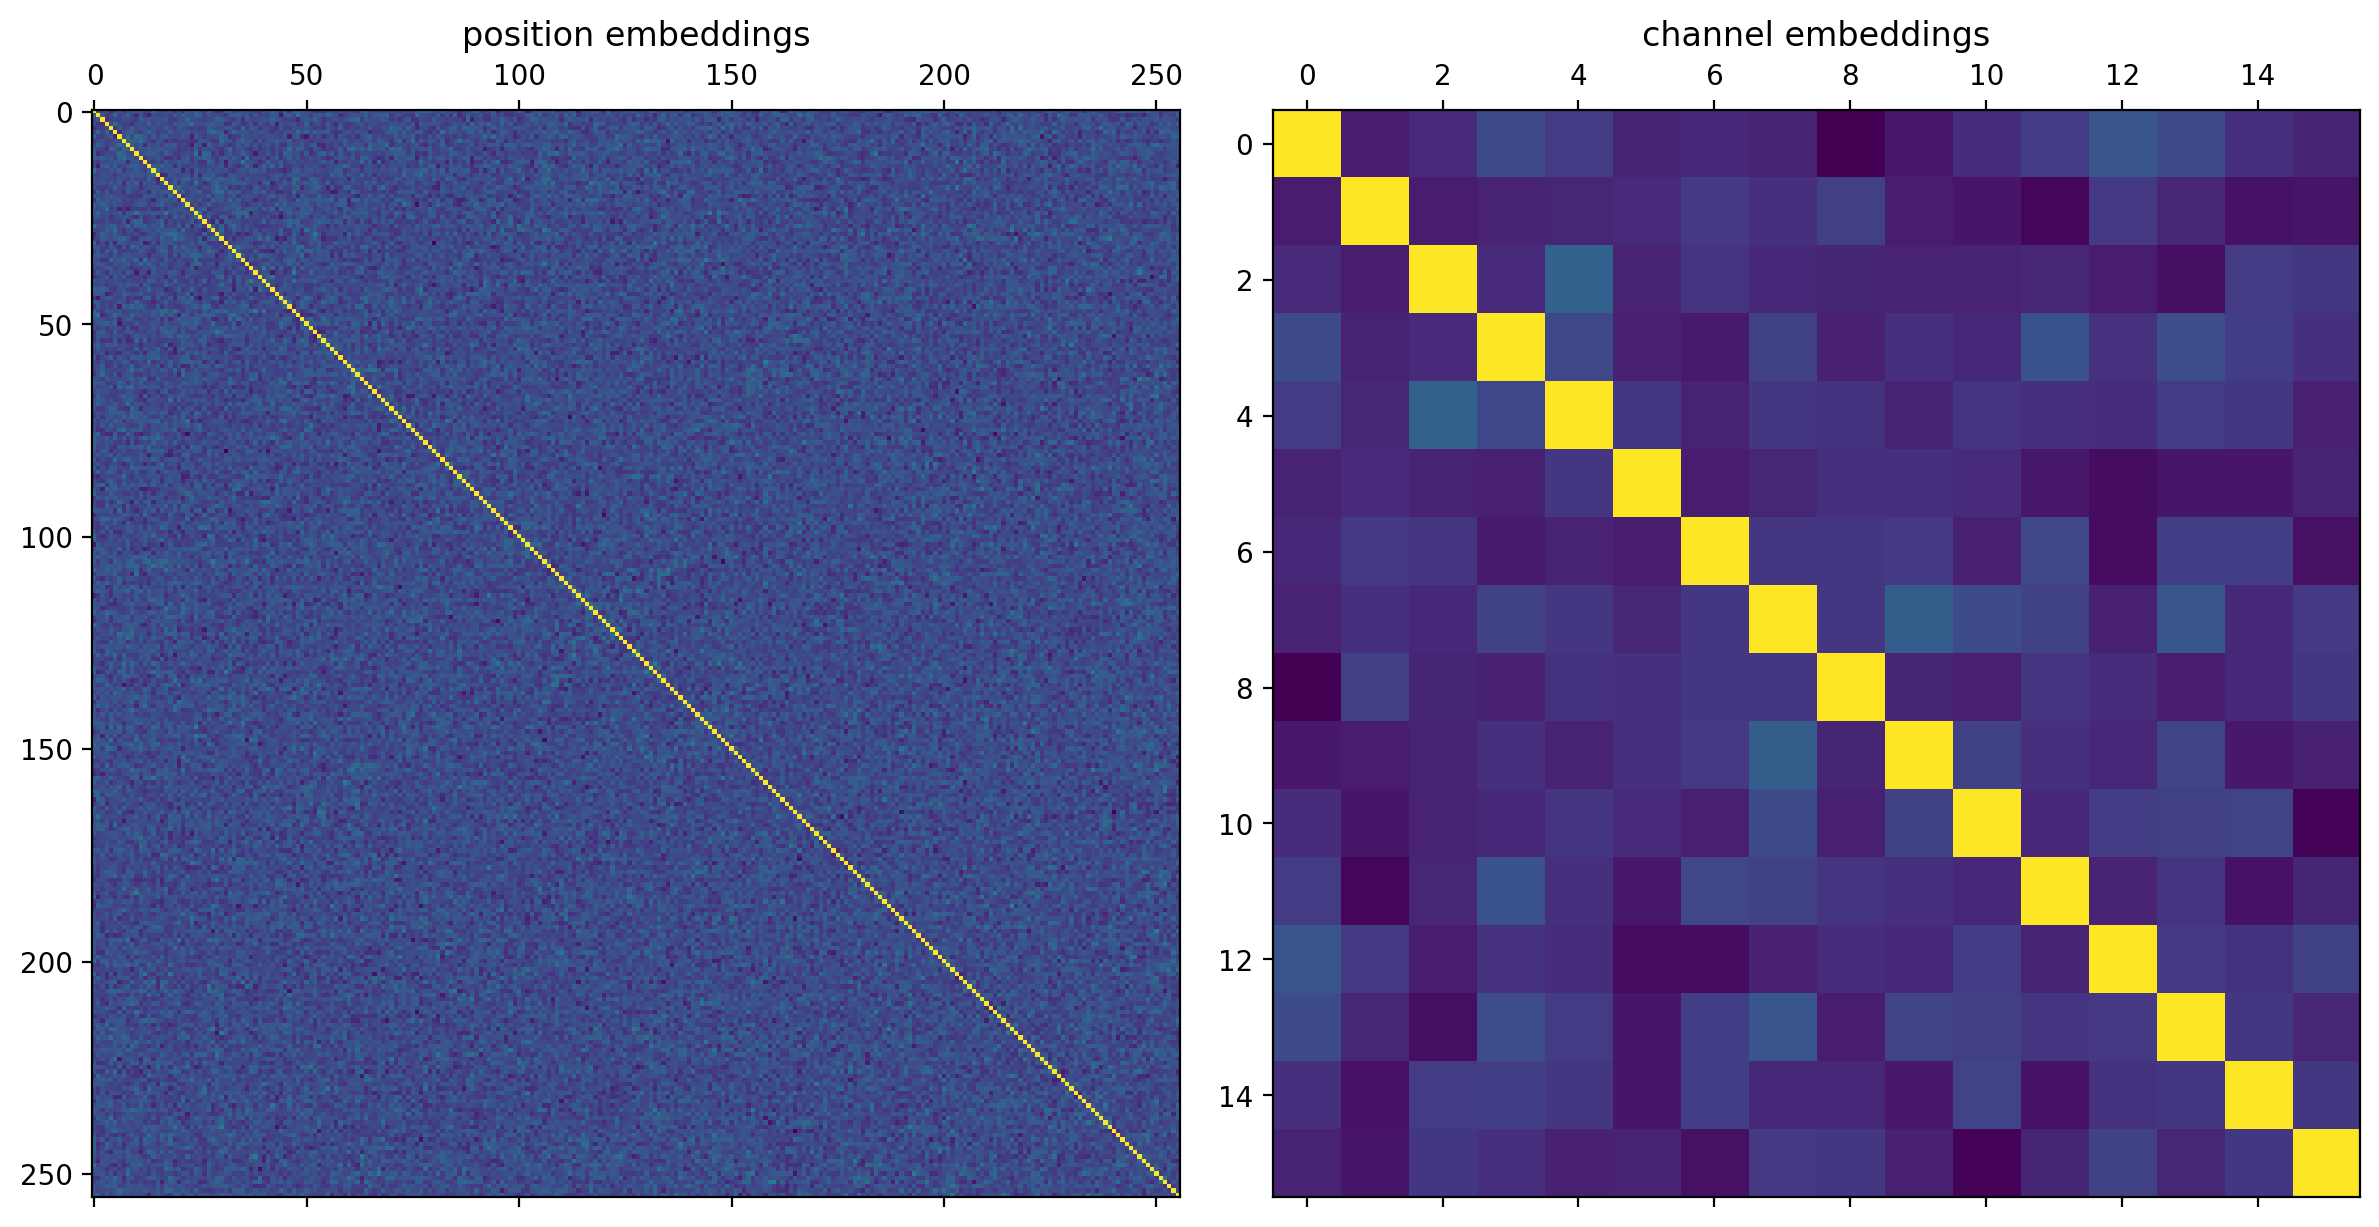

In [24]:
fig,ax = plt.subplots(1,2,figsize=(12,6),dpi=200)
locarray = np.zeros((model.pos_embed.shape[1]-1,model.pos_embed.shape[1]-1))
cos = nn.CosineSimilarity(dim=0)
for r in range(model.pos_embed.shape[1]-1):
    for c in range(model.pos_embed.shape[1]-1):
        locarray[r,c] = cos(model.pos_embed[0][r + 1],model.pos_embed[0][c + 1]).detach().cpu().numpy()
chnarray = np.zeros((reduce_dim,reduce_dim))
for r in range(reduce_dim):
    for c in range(reduce_dim):
        chnarray[r,c] = cos(model.patch_embed.channel_embed.weight[r],model.patch_embed.channel_embed.weight[c]).detach().cpu().numpy()
ax[0].set_title("position embeddings"); ax[1].set_title("channel embeddings")
ax[0].matshow(locarray); ax[1].matshow(chnarray)
fig.tight_layout()
if not is_local:
    plt.savefig(f'./position_embedding_{seed}.png'); plt.close(fig) 